In [41]:
# Import all of the basic libraries (you will always need these)
%matplotlib inline
from matplotlib import pyplot as pl
import numpy as np

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

In [42]:
# These are the van Genuchten (1980) equations
# The input is matric potential, psi and the hydraulic parameters.
# psi must be sent in as a numpy array.
# The pars variable is like a MATLAB structure.

def thetaFun(psi,pars):
    if psi>=0.:
        Se = 1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    return pars['thetaR']+(pars['thetaS']-pars['thetaR'])*Se

thetaFun=np.vectorize(thetaFun)

def CFun(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    dSedh=pars['alpha']*pars['m']/(1-pars['m'])*Se**(1/pars['m'])*(1-Se**(1/pars['m']))**pars['m']
    return Se*pars['Ss']+(pars['thetaS']-pars['thetaR'])*dSedh

CFun = np.vectorize(CFun)

def KFun(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    return pars['Ks']*Se**pars['neta']*(1-(1-Se**(1/pars['m']))**pars['m'])**2
  
KFun = np.vectorize(KFun)

def setpars():
  pars={}
  pars['thetaR']=float(raw_input("thetaR = "))
  pars['thetaS']=float(raw_input("thetaS = "))
  pars['alpha']=float(raw_input("alpha = "))
  pars['n']=float(raw_input("n = "))
  pars['m']=1-1/pars['n']
  pars['Ks']=float(raw_input("Ks = "))
  pars['neta']=float(raw_input("neta = "))
  pars['Ss']=float(raw_input("Ss = "))
  return pars
  
def PlotProps(pars):
  import numpy as np
  import pylab as pl
  import vanGenuchten as vg
  psi=np.linspace(-10,2,200)
  pl.figure
  pl.subplot(3,1,1)
  pl.plot(psi,vg.thetaFun(psi,pars))
  pl.ylabel(r'$\theta(\psi) [-]$')
  pl.subplot(3,1,2)
  pl.plot(psi,vg.CFun(psi,pars))
  pl.ylabel(r'$C(\psi) [1/m]$')
  pl.subplot(3,1,3)
  pl.plot(psi,vg.KFun(psi,pars))
  pl.xlabel(r'$\psi [m]$')
  pl.ylabel(r'$K(\psi) [m/d]$')
  #pl.show()
  
def HygieneSandstone():
  pars={}
  pars['thetaR']=0.153
  pars['thetaS']=0.25
  pars['alpha']=0.79
  pars['n']=10.4
  pars['m']=1-1/pars['n']
  pars['Ks']=1.08
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars
  
def TouchetSiltLoam():
  pars={}
  pars['thetaR']=0.19
  pars['thetaS']=0.469
  pars['alpha']=0.5
  pars['n']=7.09
  pars['m']=1-1/pars['n']
  pars['Ks']=3.03
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars

def SiltLoamGE3():
  pars={}
  pars['thetaR']=0.131
  pars['thetaS']=0.396
  pars['alpha']=0.423
  pars['n']=2.06
  pars['m']=1-1/pars['n']
  pars['Ks']=0.0496
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars
  
def GuelphLoamDrying():
  pars={}
  pars['thetaR']=0.218
  pars['thetaS']=0.520
  pars['alpha']=1.15
  pars['n']=2.03
  pars['m']=1-1/pars['n']
  pars['Ks']=0.316
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars
  
def GuelphLoamWetting():
  pars={}
  pars['thetaR']=0.218
  pars['thetaS']=0.434
  pars['alpha']=2.0
  pars['n']=2.76
  pars['m']=1-1/pars['n']
  pars['Ks']=0.316
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars
  
def BeitNetofaClay():
  pars={}
  pars['thetaR']=0.
  pars['thetaS']=0.446
  pars['alpha']=0.152
  pars['n']=1.17
  pars['m']=1-1/pars['n']
  pars['Ks']=0.00082
  pars['neta']=0.5
  pars['Ss']=0.000001
  return pars

In [43]:
# Select which soil properties to use
p=HygieneSandstone()

In [44]:
# Richards equation solver
# This is a function that calculated the right hand side of Richards' equation. You
# will not need to modify this function, unless you are doing something advanced. 
# This block of code must be executed so that the function can be later called.

def RichardsModel(psi,t,dz,n,p,qTop,qBot,psiTop,psiBot):
       
    # Basic properties:
    C=CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1)
    
    # Upper boundary
    if qTop == []:
        KTop=KFun(np.zeros(1)+psiTop,p)
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop
    
    # Lower boundary
    if qBot == []:
        if psiBot == []:
            # Free drainage
            KBot=KFun(np.zeros(1)+psi[0],p)
            q[0]=-KBot
        else:
            # Type 1 boundary
            KBot=KFun(np.zeros(1)+psiBot,p)
            q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot
    
    # Internal nodes
    i=np.arange(0,n-1)
    Knodes=KFun(psi,p)
    Kmid=(Knodes[i+1]+Knodes[i])/2.0
    
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
    
    
    # Continuity
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C
    
    return dpsidt

Text(0.5, 0, '$\\psi$')

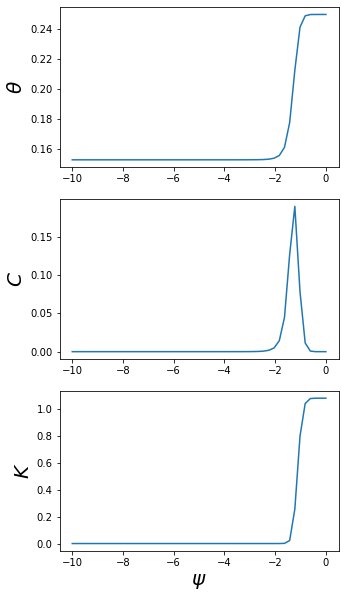

In [45]:
psi = np.linspace(-10,0)
theta = thetaFun(psi,p)
C=CFun(psi,p)
K=KFun(psi,p)

pl.rcParams['figure.figsize'] = (5.0, 10.0)
pl.subplot(311)
pl.plot(psi,theta)
pl.ylabel(r'$\theta$', fontsize=20)
pl.subplot(312)
pl.plot(psi,C)
pl.ylabel(r'$C$',fontsize=20)
pl.subplot(313)
pl.plot(psi,K)
pl.ylabel(r'$K$', fontsize=20)
pl.xlabel(r'$\psi$', fontsize=20)

In [46]:
# This block of code sets up and runs the model

# Boundary conditions
qTop=-0.01
qBot=[]
psiTop=[]
psiBot=[]

# Grid in space
dz=0.1
ProfileDepth=5
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,10,101)

# Initial conditions
psi0=-z

# Solve
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,qTop,qBot,psiTop,psiBot),mxstep=5000000);

print("Model run successfully")    

Model run successfully


In [47]:
# Post process model output to get useful information

# Get water content
theta=thetaFun(psi,p)

# Get total profile storage
S=theta.sum(axis=1)*dz

# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])

# Get infiltration flux
if qTop == []:
    KTop=KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop
    
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot

Text(0.5, 0, '$\\theta$ [-]')

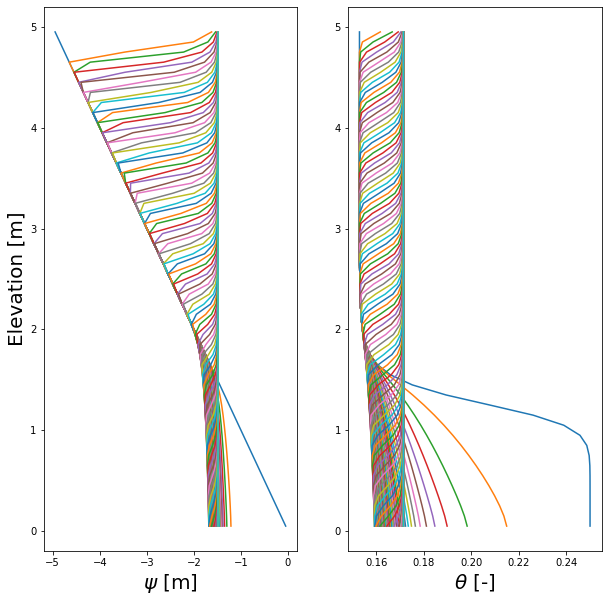

In [48]:
# Plot vertical profiles
pl.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size-1):
    pl.subplot(121)
    pl.plot(psi[i,:],z)
    pl.subplot(122)
    pl.plot(theta[i,:],z)

pl.subplot(121)
pl.ylabel('Elevation [m]',fontsize=20)
pl.xlabel(r'$\psi$ [m]',fontsize=20)
pl.subplot(122)
pl.xlabel(r'$\theta$ [-]',fontsize=20)

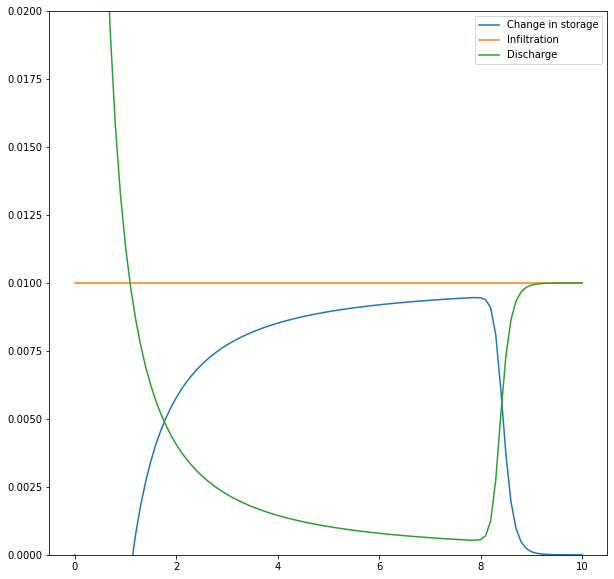

In [49]:
# Plot timeseries
dt = t[2]-t[1]
pl.plot(t,dS,label='Change in storage')
pl.plot(t,-qI,label='Infiltration')
pl.plot(t,-qD,label='Discharge')
pl.ylim((0,0.02))
pl.legend()